In [83]:

import numpy as np
import pickle
import lzma
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.typing import NDArray
from experiment import AgentStats, Results
from typing import List, Dict
from scipy.ndimage import gaussian_filter
from matplotlib.colors import Normalize

In [84]:
TITLE_SIZE = 22
LEGEND_SIZE = 14
TICK_SIZE = 14
AXIS_TITLE = TITLE_SIZE-4
AXIS_LABEL = 16
FONT_SIZE = TITLE_SIZE-4

rc_parameters = {
    "font.size": FONT_SIZE,
    "axes.titlesize": AXIS_TITLE,
    "axes.labelsize": AXIS_LABEL,
    "xtick.labelsize": TICK_SIZE,
    "ytick.labelsize": TICK_SIZE,
    "legend.fontsize": LEGEND_SIZE,
    "figure.titlesize": TITLE_SIZE,
    "font.family": "serif",  # use serif/main font for text elements
    "text.usetex": True,  # use inline math for ticks
    "pgf.rcfonts": False,  # don't setup fonts from rc parameters
    "pgf.preamble":  r'\usepackage{amsmath}'
}
plt.rcParams.update(rc_parameters)


In [85]:
agents = ['dbmfbpi','bsp','bsp2', 'ids']
titles = {
    'dbmfbpi': 'Model-Free Best Policy\nIdentification (ours)',
    'bsp': 'Boostrapped DQN with\n Randomized Prior',
    'ids': 'Information Directed\nSampling'
}
difficulty = 5
data = {}
for agent in agents:
    data[agent] = {}
    with lzma.open(f'data//data_{difficulty}_{agent}.pkl.lzma', 'rb') as f:
        data[agent][difficulty] = pickle.load(f)


In [86]:
T = 20000   # Total timesteps considered
runs = 30    # Specify number of runs
x = np.zeros((3, runs, T))
xdot = np.zeros((3, runs, T))
theta = np.zeros((3, runs, T))
thetadot = np.zeros((3, runs, T))
timestamps = np.zeros((3, runs,T))
states = np.zeros((3, runs, T, 8))

for idx, agent in enumerate(['bsp', 'ids', 'dbmfbpi']):
    for n in range(runs):
        timesteps, episodes, _states, actions= map(np.array, zip(*data[agent][difficulty][n].agent_stats.states_actions_visited))
        timestamps[idx, n, :] = timesteps[:T]
        x[idx, n, :]= _states[:T,0]
        xdot[idx, n, :] = _states[:T,1]
        theta[idx, n, :] = np.arctan2(_states[:T, 3], _states[:T, 2])
        thetadot[idx, n, :] = _states[:T, 4]
        states[idx, n, :] = _states[:T]

def compute_entropy(hist):
    prob = hist / np.sum(hist)
    entropy = -np.sum(prob * np.log(prob + np.finfo(float).eps))
    return entropy

x_norm = (x - x.min()) / (x.max() - x.min())
xdot_norm = (xdot - xdot.min()) / (xdot.max() - xdot.min())
theta_norm = (theta - theta.min()) / (theta.max() - theta.min())
thetadot_norm = (thetadot - thetadot.min()) / (thetadot.max() - thetadot.min())


In [87]:
sns.set_style("darkgrid", rc=rc_parameters)
bins = int(np.ceil(np.log2(T) + 1))
points = np.linspace(100, T, num=int( T/500), dtype=np.int64)
results = np.zeros((3, len(points), runs))
df_freq_visit = pd.DataFrame({}, columns=['t', 'entropy', 'agent'])


LABELS = {
    'bsp': 'BSP',
    'bsp2': 'BSP2',
    'dbmfbpi': 'DBMF-BPI',
    'ids': 'IDS',
}
colors = ['#f8766d', '#00bfc4', 'mediumorchid','#3B3B3B','#0096FF','#a3a500']
color_dict = {agent: color for agent, color in zip(['BSP', 'DBMF-BPI', 'IDS', 'BSP2'], colors)}

for idx, agent in enumerate(['bsp', 'ids', 'dbmfbpi']):
    for n in range(runs):
        for tidx, t in enumerate(points):
            var1, var2,var3,var4, tm = x_norm[idx,n,:t+1], xdot_norm[idx,n,:t+1],theta_norm[idx,n,:t+1], thetadot_norm[idx,n,:t+1], timestamps[idx,n,:t+1]
            vars = np.vstack([var1, var2, var3,var4]).T
            hist, edges = np.histogramdd(vars, bins=bins)
            results[idx,tidx,n] = compute_entropy(hist) / np.log(np.prod(hist.shape))
            df_freq_visit.loc[len(df_freq_visit)] = {'t': t, 'entropy': results[idx, tidx,n], 'agent': LABELS[agent]}

In [88]:
bins = int(np.ceil(np.log2(T) + 1))

var1, var2,var3,var4 = x_norm[0,0,:], xdot_norm[0,0,:],theta_norm[0,0,:], thetadot_norm[0,0,:]
vars = np.vstack([var1, var2, var3,var4]).T
hist, edges = np.histogramdd(vars, bins=bins)
points = np.linspace(100, T, num=int( T/500), dtype=np.int64)
df_last_visit = pd.DataFrame({}, columns=['t', 'entropy', 'agent'])

entropies = np.zeros((3, runs, len(points)))
for idx, agent in enumerate(['bsp', 'ids', 'dbmfbpi']):
    for n in range(runs):
        for tidx, t in enumerate(points):
            var1, var2,var3,var4, tm = x_norm[idx,n,:t+1], xdot_norm[idx,n,:t+1],theta_norm[idx,n,:t+1], thetadot_norm[idx,n,:t+1], timestamps[idx,n,:t+1]
            vars = np.vstack([var1, var2, var3,var4]).T
            hist, edges = np.histogramdd(vars, bins=bins)
            x_idx = np.digitize(var1, edges[0]) - 1
            y_idx = np.digitize(var2, edges[1]) - 1
            z_idx = np.digitize(var3, edges[2]) - 1
            w_idx = np.digitize(var4, edges[3]) - 1

            recency_map = np.zeros((bins+1, bins+1, bins+1, bins+1))
            flattened_view = recency_map.ravel()
            recency_map[x_idx, y_idx, z_idx, w_idx] = tm + 1
            rec = flattened_view / flattened_view.sum()

            entropies[idx, n, tidx] = -(rec * np.log(1e-6 + rec)).sum() / np.log(np.prod(recency_map.shape))
            df_last_visit.loc[len(df_last_visit)] = {'t': t, 'entropy': entropies[idx, n, tidx], 'agent': LABELS[agent]}



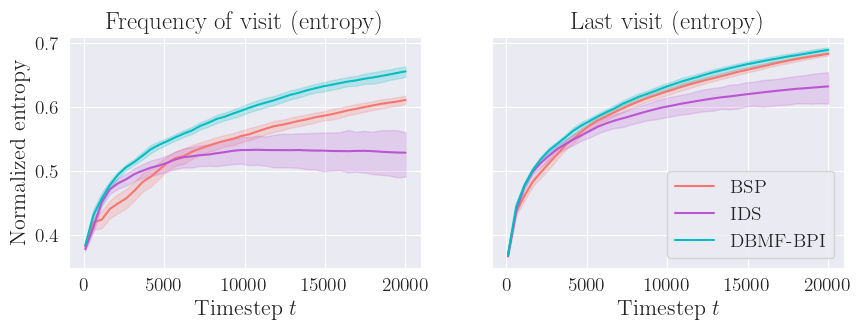

In [89]:
fig, ax = plt.subplots(1,2, figsize=(10,3), sharey=True)
sns.lineplot(x='t', y='entropy', hue='agent', data=df_freq_visit, palette=color_dict, ax=ax[0])
sns.lineplot(x='t', y='entropy', hue='agent', data=df_last_visit, palette=color_dict, ax=ax[1])


ax[0].set_xlabel(r'$\mathrm{Timestep}$ $t$')
ax[1].set_xlabel(r'$\mathrm{Timestep}$ $t$')
ax[0].set_ylabel(r'$\mathrm{Normalized \ entropy}$')
ax[0].set_title(r'Frequency of visit (entropy)')
ax[1].set_title(r'Last visit (entropy)')
ax[0].get_legend().remove() 
ax[1].get_legend().remove() 
plt.legend()
plt.savefig(f'figures/exploration_entropy_{difficulty}.pdf', bbox_inches='tight')
plt.show()
